<a href="https://colab.research.google.com/github/9-coding/ComputerVision_TeamProject/blob/main/ActiveLerning1_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [15]:
import os
# 각자 환경에서 이 부분만 변경하여 사용하면 됩니다.
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Computer_Vision/ActiveLearning/CUB_200_2011_repackage_class50')
print(os.getcwd())


/content/gdrive/MyDrive/Colab Notebooks/Computer_Vision/ActiveLearning/CUB_200_2011_repackage_class50


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

### Custom Dataset ###
class CUB2011(Dataset):
    def __init__(self, transform, mode='train'):
        self.transform = transform
        self.mode = mode
        self.image_folder = os.listdir(f'./datasets/{mode}')

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img_path = self.image_folder[idx]
        img = Image.open(os.path.join('./datasets', self.mode, img_path)).convert('RGB')
        img = self.transform(img)
        label = int(img_path.split('_')[-1].split('.')[0])
        return (img, label)



cuda


In [21]:
### Data Augmentation ###
param_dist = {
    'brightness': np.random.uniform(0.5, 0.8),
    'contrast': np.random.uniform(0.0, 1.0),
    'saturation': np.random.uniform(0.5, 0.8),
    'hue': np.random.uniform(0.0, 0.5)
}

color_jitter = transforms.ColorJitter(
    brightness=param_dist['brightness'],
    contrast=param_dist['contrast'],
    saturation=param_dist['saturation'],
    hue=param_dist['hue']
)

def transforms_func(transform):
  return transforms.Compose([
    transforms.Resize((448, 448)),
    transform,
    transforms.ToTensor(),
])

# 회전
ROTATION_DEGREE = 30
transforms_rotation = transforms_func(transforms.RandomRotation(degrees=ROTATION_DEGREE))

# 수평으로 뒤집기
transforms_horizontal_flip = transforms_func(transforms.RandomHorizontalFlip(p=1.0))

# 색상 변환
transforms_color = transforms_func(color_jitter)

transforms_train_with_augmentation = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transforms_valtest = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


In [22]:

BATCH_SIZE = 32

train_set_with_augmentation = CUB2011(mode='train', transform=transforms_train_with_augmentation)

train_set_rotation = CUB2011(mode='train', transform=transforms_rotation)
train_set_horizontal_flip = CUB2011(mode='train', transform=transforms_horizontal_flip)
train_set_color = CUB2011(mode='train', transform=transforms_color)

combined_train_set = train_set_with_augmentation+ train_set_rotation+ train_set_horizontal_flip+ train_set_color

val_set = CUB2011(mode='valid', transform=transforms_valtest)
test_set = CUB2011(mode='test', transform=transforms_valtest)

train_loader_with_augmentation = DataLoader(combined_train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

### Model / Optimizer ###
EPOCH = 10
lr = 0.1
model_with_augmentation = models.resnet18(pretrained=True)

num_features = model_with_augmentation.fc.in_features

# Adjusting for augmentation
model_with_augmentation.fc = nn.Linear(num_features, 50)
model_with_augmentation = model_with_augmentation.to(DEVICE)
optimizer_with_augmentation = optim.SGD(model_with_augmentation.parameters(), lr=lr)



In [23]:

### Train/Evaluation ###
def train(model, train_loader, optimizer, epoch):
    model.train()
    for i, (image, target) in enumerate(train_loader):
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        train_loss = F.cross_entropy(output, target).to(DEVICE)
        train_loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f'Train Epoch {epoch} [{i}/{len(train_loader)}]\tLoss: {train_loss.item():.6f}')
    return train_loss

def evaluate(model, val_loader):
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image, target = image.to(DEVICE), target.to(DEVICE)
            output = model(image)
            eval_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        eval_loss /= len(val_loader.dataset)
        eval_accuracy = 100 * correct / len(val_loader.dataset)
        return eval_loss, eval_accuracy



Train Epoch 0 [0/295]	Loss: 4.192798
Train Epoch 0 [10/295]	Loss: 4.285169
Train Epoch 0 [20/295]	Loss: 3.357964
Train Epoch 0 [30/295]	Loss: 3.054913
Train Epoch 0 [40/295]	Loss: 2.491910
Train Epoch 0 [50/295]	Loss: 1.831345
Train Epoch 0 [60/295]	Loss: 1.828582
Train Epoch 0 [70/295]	Loss: 1.672456
Train Epoch 0 [80/295]	Loss: 1.568266
Train Epoch 0 [90/295]	Loss: 1.270557
Train Epoch 0 [100/295]	Loss: 1.368996
Train Epoch 0 [110/295]	Loss: 0.592385
Train Epoch 0 [120/295]	Loss: 1.295585
Train Epoch 0 [130/295]	Loss: 1.104892
Train Epoch 0 [140/295]	Loss: 1.028763
Train Epoch 0 [150/295]	Loss: 0.868037
Train Epoch 0 [160/295]	Loss: 0.591803
Train Epoch 0 [170/295]	Loss: 0.360009
Train Epoch 0 [180/295]	Loss: 0.754417
Train Epoch 0 [190/295]	Loss: 0.567122
Train Epoch 0 [200/295]	Loss: 0.466352
Train Epoch 0 [210/295]	Loss: 0.609093
Train Epoch 0 [220/295]	Loss: 0.368721
Train Epoch 0 [230/295]	Loss: 0.395029
Train Epoch 0 [240/295]	Loss: 0.342799
Train Epoch 0 [250/295]	Loss: 0.3177

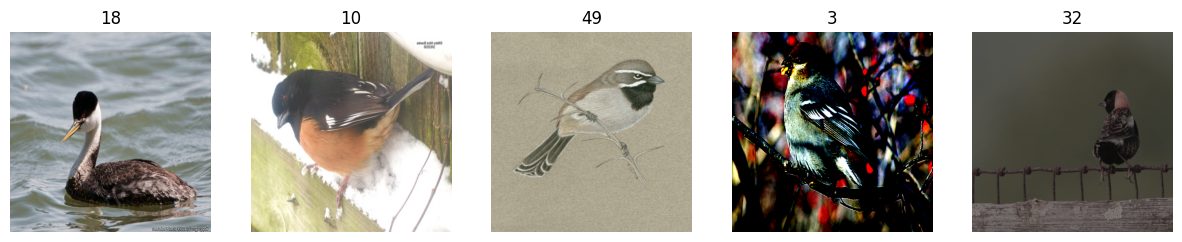

Epoch 0
With Augmentation - Train Loss: 0.2365, Validation Loss: 0.5835, Validation Accuracy: 83.45%
Train Epoch 1 [0/295]	Loss: 0.318859
Train Epoch 1 [10/295]	Loss: 0.319343
Train Epoch 1 [20/295]	Loss: 0.253216
Train Epoch 1 [30/295]	Loss: 0.217476
Train Epoch 1 [40/295]	Loss: 0.269923
Train Epoch 1 [50/295]	Loss: 0.271022
Train Epoch 1 [60/295]	Loss: 0.150611
Train Epoch 1 [70/295]	Loss: 0.277459
Train Epoch 1 [80/295]	Loss: 0.515798
Train Epoch 1 [90/295]	Loss: 0.318878
Train Epoch 1 [100/295]	Loss: 0.184466
Train Epoch 1 [110/295]	Loss: 0.203148
Train Epoch 1 [120/295]	Loss: 0.303645
Train Epoch 1 [130/295]	Loss: 0.158596
Train Epoch 1 [140/295]	Loss: 0.102987
Train Epoch 1 [150/295]	Loss: 0.313213
Train Epoch 1 [160/295]	Loss: 0.336696
Train Epoch 1 [170/295]	Loss: 0.222342
Train Epoch 1 [180/295]	Loss: 0.114328
Train Epoch 1 [190/295]	Loss: 0.139022
Train Epoch 1 [200/295]	Loss: 0.217533
Train Epoch 1 [210/295]	Loss: 0.175634
Train Epoch 1 [220/295]	Loss: 0.304191
Train Epoch 1

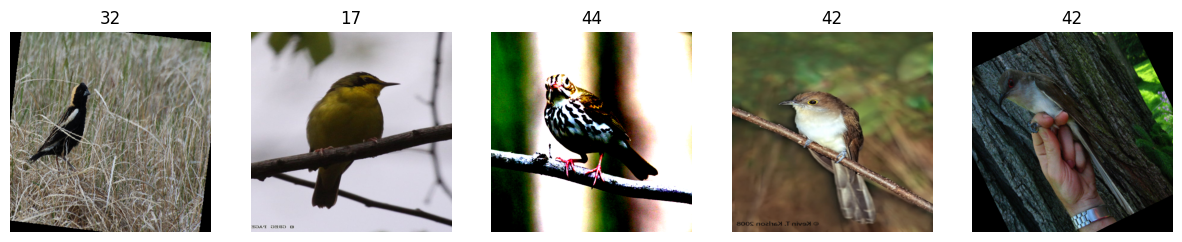

Epoch 1
With Augmentation - Train Loss: 0.2276, Validation Loss: 0.6024, Validation Accuracy: 83.45%
Train Epoch 2 [0/295]	Loss: 0.345670
Train Epoch 2 [10/295]	Loss: 0.134095
Train Epoch 2 [20/295]	Loss: 0.069122
Train Epoch 2 [30/295]	Loss: 0.095286
Train Epoch 2 [40/295]	Loss: 0.036771
Train Epoch 2 [50/295]	Loss: 0.057986
Train Epoch 2 [60/295]	Loss: 0.062881
Train Epoch 2 [70/295]	Loss: 0.069448
Train Epoch 2 [80/295]	Loss: 0.138733
Train Epoch 2 [90/295]	Loss: 0.092851
Train Epoch 2 [100/295]	Loss: 0.049334
Train Epoch 2 [110/295]	Loss: 0.113519
Train Epoch 2 [120/295]	Loss: 0.042089
Train Epoch 2 [130/295]	Loss: 0.097515
Train Epoch 2 [140/295]	Loss: 0.059301
Train Epoch 2 [150/295]	Loss: 0.044019
Train Epoch 2 [160/295]	Loss: 0.021325
Train Epoch 2 [170/295]	Loss: 0.061550
Train Epoch 2 [180/295]	Loss: 0.029057
Train Epoch 2 [190/295]	Loss: 0.085551
Train Epoch 2 [200/295]	Loss: 0.035918
Train Epoch 2 [210/295]	Loss: 0.019424
Train Epoch 2 [220/295]	Loss: 0.143161
Train Epoch 2

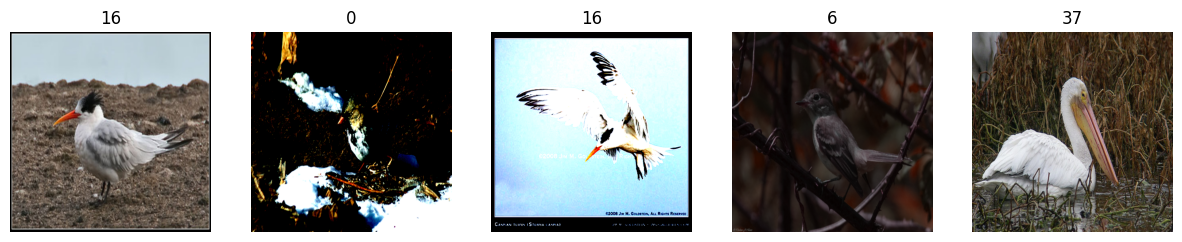

Epoch 2
With Augmentation - Train Loss: 0.0302, Validation Loss: 0.3994, Validation Accuracy: 90.88%
Train Epoch 3 [0/295]	Loss: 0.038976
Train Epoch 3 [10/295]	Loss: 0.055141
Train Epoch 3 [20/295]	Loss: 0.041380
Train Epoch 3 [30/295]	Loss: 0.024736
Train Epoch 3 [40/295]	Loss: 0.017149
Train Epoch 3 [50/295]	Loss: 0.025715
Train Epoch 3 [60/295]	Loss: 0.018948
Train Epoch 3 [70/295]	Loss: 0.022729
Train Epoch 3 [80/295]	Loss: 0.019542
Train Epoch 3 [90/295]	Loss: 0.027921
Train Epoch 3 [100/295]	Loss: 0.015466
Train Epoch 3 [110/295]	Loss: 0.027301
Train Epoch 3 [120/295]	Loss: 0.030679
Train Epoch 3 [130/295]	Loss: 0.047660
Train Epoch 3 [140/295]	Loss: 0.091854
Train Epoch 3 [150/295]	Loss: 0.027900
Train Epoch 3 [160/295]	Loss: 0.022357
Train Epoch 3 [170/295]	Loss: 0.027146
Train Epoch 3 [180/295]	Loss: 0.072491
Train Epoch 3 [190/295]	Loss: 0.037482
Train Epoch 3 [200/295]	Loss: 0.029163
Train Epoch 3 [210/295]	Loss: 0.013147
Train Epoch 3 [220/295]	Loss: 0.012820
Train Epoch 3

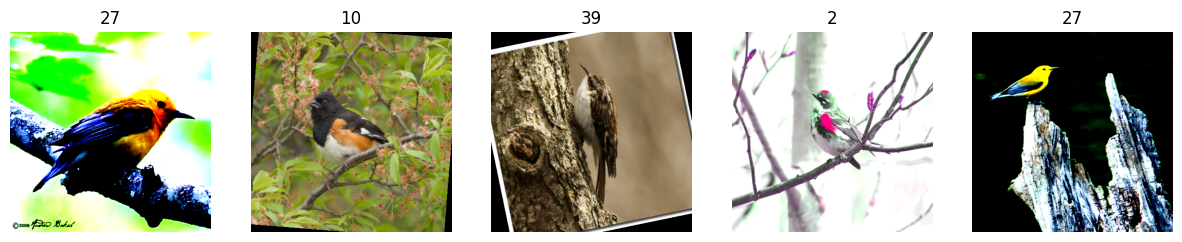

Epoch 3
With Augmentation - Train Loss: 0.0155, Validation Loss: 0.3080, Validation Accuracy: 91.55%
Train Epoch 4 [0/295]	Loss: 0.072174
Train Epoch 4 [10/295]	Loss: 0.010280
Train Epoch 4 [20/295]	Loss: 0.010622
Train Epoch 4 [30/295]	Loss: 0.031470
Train Epoch 4 [40/295]	Loss: 0.028464
Train Epoch 4 [50/295]	Loss: 0.013333
Train Epoch 4 [60/295]	Loss: 0.009603
Train Epoch 4 [70/295]	Loss: 0.020857
Train Epoch 4 [80/295]	Loss: 0.030321
Train Epoch 4 [90/295]	Loss: 0.007263
Train Epoch 4 [100/295]	Loss: 0.006389
Train Epoch 4 [110/295]	Loss: 0.008297
Train Epoch 4 [120/295]	Loss: 0.010595
Train Epoch 4 [130/295]	Loss: 0.013092
Train Epoch 4 [140/295]	Loss: 0.068075
Train Epoch 4 [150/295]	Loss: 0.067709
Train Epoch 4 [160/295]	Loss: 0.004641
Train Epoch 4 [170/295]	Loss: 0.007804
Train Epoch 4 [180/295]	Loss: 0.008470
Train Epoch 4 [190/295]	Loss: 0.015702
Train Epoch 4 [200/295]	Loss: 0.006817
Train Epoch 4 [210/295]	Loss: 0.015232
Train Epoch 4 [220/295]	Loss: 0.014935
Train Epoch 4

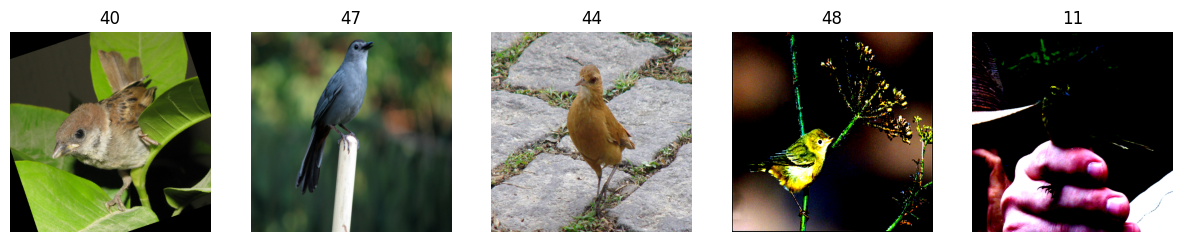

Epoch 4
With Augmentation - Train Loss: 0.0306, Validation Loss: 0.2926, Validation Accuracy: 92.23%
Train Epoch 5 [0/295]	Loss: 0.003445
Train Epoch 5 [10/295]	Loss: 0.007320
Train Epoch 5 [20/295]	Loss: 0.004593
Train Epoch 5 [30/295]	Loss: 0.035315
Train Epoch 5 [40/295]	Loss: 0.004784
Train Epoch 5 [50/295]	Loss: 0.005294
Train Epoch 5 [60/295]	Loss: 0.011707
Train Epoch 5 [70/295]	Loss: 0.005189
Train Epoch 5 [80/295]	Loss: 0.002787
Train Epoch 5 [90/295]	Loss: 0.015561
Train Epoch 5 [100/295]	Loss: 0.004161
Train Epoch 5 [110/295]	Loss: 0.012070
Train Epoch 5 [120/295]	Loss: 0.002198
Train Epoch 5 [130/295]	Loss: 0.004174
Train Epoch 5 [140/295]	Loss: 0.029308
Train Epoch 5 [150/295]	Loss: 0.007627
Train Epoch 5 [160/295]	Loss: 0.008274
Train Epoch 5 [170/295]	Loss: 0.008436
Train Epoch 5 [180/295]	Loss: 0.020352
Train Epoch 5 [190/295]	Loss: 0.004225
Train Epoch 5 [200/295]	Loss: 0.004530
Train Epoch 5 [210/295]	Loss: 0.005102
Train Epoch 5 [220/295]	Loss: 0.060241
Train Epoch 5

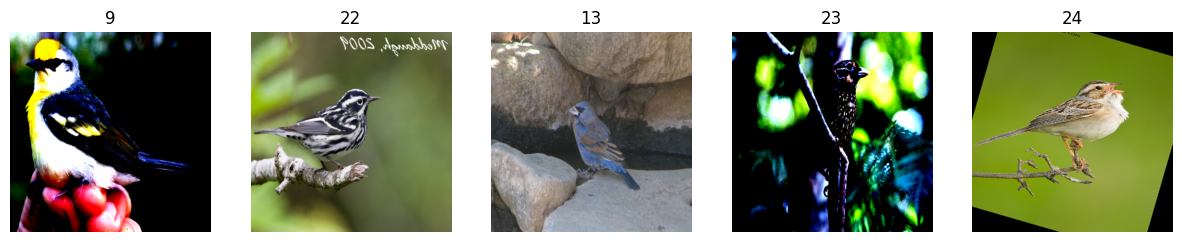

Epoch 5
With Augmentation - Train Loss: 0.0185, Validation Loss: 0.3065, Validation Accuracy: 92.57%
Train Epoch 6 [0/295]	Loss: 0.008484
Train Epoch 6 [10/295]	Loss: 0.003480
Train Epoch 6 [20/295]	Loss: 0.005435
Train Epoch 6 [30/295]	Loss: 0.006402
Train Epoch 6 [40/295]	Loss: 0.006999
Train Epoch 6 [50/295]	Loss: 0.003265
Train Epoch 6 [60/295]	Loss: 0.013291
Train Epoch 6 [70/295]	Loss: 0.007819
Train Epoch 6 [80/295]	Loss: 0.008903
Train Epoch 6 [90/295]	Loss: 0.003002
Train Epoch 6 [100/295]	Loss: 0.005075
Train Epoch 6 [110/295]	Loss: 0.004001
Train Epoch 6 [120/295]	Loss: 0.006591
Train Epoch 6 [130/295]	Loss: 0.036074
Train Epoch 6 [140/295]	Loss: 0.006700
Train Epoch 6 [150/295]	Loss: 0.013923
Train Epoch 6 [160/295]	Loss: 0.008483
Train Epoch 6 [170/295]	Loss: 0.008289
Train Epoch 6 [180/295]	Loss: 0.009066
Train Epoch 6 [190/295]	Loss: 0.006842
Train Epoch 6 [200/295]	Loss: 0.029641
Train Epoch 6 [210/295]	Loss: 0.013955
Train Epoch 6 [220/295]	Loss: 0.024652
Train Epoch 6

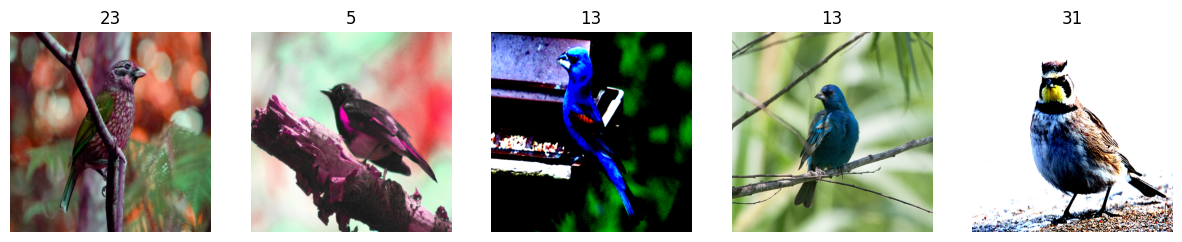

Epoch 6
With Augmentation - Train Loss: 0.0045, Validation Loss: 0.3261, Validation Accuracy: 90.54%
Train Epoch 7 [0/295]	Loss: 0.009193
Train Epoch 7 [10/295]	Loss: 0.005869
Train Epoch 7 [20/295]	Loss: 0.003430
Train Epoch 7 [30/295]	Loss: 0.004303
Train Epoch 7 [40/295]	Loss: 0.004499
Train Epoch 7 [50/295]	Loss: 0.005344
Train Epoch 7 [60/295]	Loss: 0.002246
Train Epoch 7 [70/295]	Loss: 0.002377
Train Epoch 7 [80/295]	Loss: 0.006294
Train Epoch 7 [90/295]	Loss: 0.005167
Train Epoch 7 [100/295]	Loss: 0.003214
Train Epoch 7 [110/295]	Loss: 0.005894
Train Epoch 7 [120/295]	Loss: 0.006721
Train Epoch 7 [130/295]	Loss: 0.005645
Train Epoch 7 [140/295]	Loss: 0.004952
Train Epoch 7 [150/295]	Loss: 0.002822
Train Epoch 7 [160/295]	Loss: 0.005432
Train Epoch 7 [170/295]	Loss: 0.010357
Train Epoch 7 [180/295]	Loss: 0.002910
Train Epoch 7 [190/295]	Loss: 0.006891
Train Epoch 7 [200/295]	Loss: 0.006115
Train Epoch 7 [210/295]	Loss: 0.005026
Train Epoch 7 [220/295]	Loss: 0.004553
Train Epoch 7

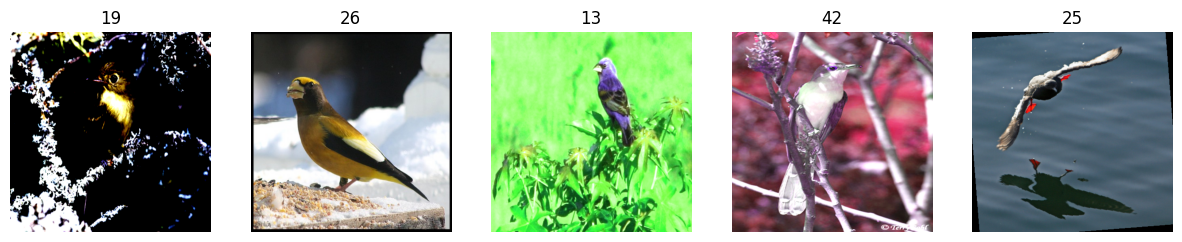

Epoch 7
With Augmentation - Train Loss: 0.0224, Validation Loss: 0.4391, Validation Accuracy: 88.51%
Train Epoch 8 [0/295]	Loss: 0.014321
Train Epoch 8 [10/295]	Loss: 0.017474
Train Epoch 8 [20/295]	Loss: 0.003130
Train Epoch 8 [30/295]	Loss: 0.007446
Train Epoch 8 [40/295]	Loss: 0.004329
Train Epoch 8 [50/295]	Loss: 0.001781
Train Epoch 8 [60/295]	Loss: 0.006437
Train Epoch 8 [70/295]	Loss: 0.001826
Train Epoch 8 [80/295]	Loss: 0.031872
Train Epoch 8 [90/295]	Loss: 0.005142
Train Epoch 8 [100/295]	Loss: 0.003218
Train Epoch 8 [110/295]	Loss: 0.006508
Train Epoch 8 [120/295]	Loss: 0.004368
Train Epoch 8 [130/295]	Loss: 0.003001
Train Epoch 8 [140/295]	Loss: 0.006594
Train Epoch 8 [150/295]	Loss: 0.002509
Train Epoch 8 [160/295]	Loss: 0.003066
Train Epoch 8 [170/295]	Loss: 0.010892
Train Epoch 8 [180/295]	Loss: 0.003707
Train Epoch 8 [190/295]	Loss: 0.006577
Train Epoch 8 [200/295]	Loss: 0.015455
Train Epoch 8 [210/295]	Loss: 0.013660
Train Epoch 8 [220/295]	Loss: 0.064922
Train Epoch 8

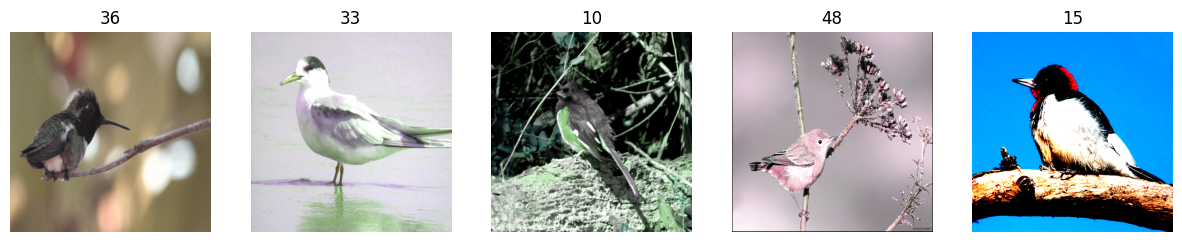

Epoch 8
With Augmentation - Train Loss: 0.0074, Validation Loss: 0.2788, Validation Accuracy: 92.23%
Train Epoch 9 [0/295]	Loss: 0.004396
Train Epoch 9 [10/295]	Loss: 0.002340
Train Epoch 9 [20/295]	Loss: 0.002826
Train Epoch 9 [30/295]	Loss: 0.003775
Train Epoch 9 [40/295]	Loss: 0.007318
Train Epoch 9 [50/295]	Loss: 0.003338
Train Epoch 9 [60/295]	Loss: 0.002034
Train Epoch 9 [70/295]	Loss: 0.004458
Train Epoch 9 [80/295]	Loss: 0.008535
Train Epoch 9 [90/295]	Loss: 0.002970
Train Epoch 9 [100/295]	Loss: 0.002406
Train Epoch 9 [110/295]	Loss: 0.004716
Train Epoch 9 [120/295]	Loss: 0.003837
Train Epoch 9 [130/295]	Loss: 0.002730
Train Epoch 9 [140/295]	Loss: 0.010874
Train Epoch 9 [150/295]	Loss: 0.007035
Train Epoch 9 [160/295]	Loss: 0.002726
Train Epoch 9 [170/295]	Loss: 0.003808
Train Epoch 9 [180/295]	Loss: 0.002018
Train Epoch 9 [190/295]	Loss: 0.002922
Train Epoch 9 [200/295]	Loss: 0.018932
Train Epoch 9 [210/295]	Loss: 0.002177
Train Epoch 9 [220/295]	Loss: 0.002453
Train Epoch 9

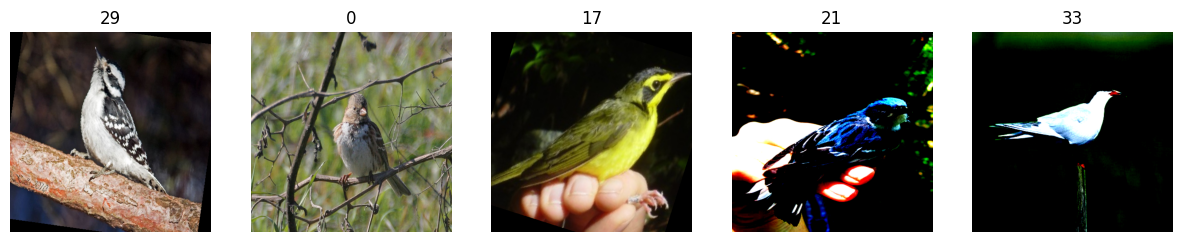

Epoch 9
With Augmentation - Train Loss: 0.0026, Validation Loss: 0.2729, Validation Accuracy: 92.91%
[FINAL with Augmentation] Test Loss: 0.3885, Accuracy: 89.9329%
Best Accuracy with Augmentation: 92.91%
Elapsed Time: 0h, 31m, 6s
time: 0h, 31m, 6s


In [24]:
### Main ###
start = time.time()
best_with_augmentation = 0
best_without_augmentation = 0

for epoch in range(EPOCH):
    # With Augmentation
    train_loss_with_augmentation = train(model_with_augmentation, train_loader_with_augmentation, optimizer_with_augmentation, epoch)
    val_loss_with_augmentation, val_accuracy_with_augmentation = evaluate(model_with_augmentation, val_loader)

    # Save best model
    if val_accuracy_with_augmentation > best_with_augmentation:
        best_with_augmentation = val_accuracy_with_augmentation
        torch.save(model_with_augmentation.state_dict(), "./best_model_with_augmentation.pth")

    # augmentation 적용한 이미지 보기
    dataiter = iter(train_loader_with_augmentation)
    images, labels = dataiter.__next__()
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
      image = images[i].numpy().transpose((1, 2, 0))
      image = np.clip(image, 0, 1)
      axes[i].imshow(image)
      axes[i].set_title(labels[i].item())
      axes[i].axis('off')
    plt.show()

    print(f'Epoch {epoch}')
    print(f"With Augmentation - Train Loss: {train_loss_with_augmentation.item():.4f}, Validation Loss: {val_loss_with_augmentation:.4f}, Validation Accuracy: {val_accuracy_with_augmentation:.2f}%")

# Test results
test_loss_with_augmentation, test_accuracy_with_augmentation = evaluate(model_with_augmentation, test_loader)

print(f'[FINAL with Augmentation] Test Loss: {test_loss_with_augmentation:.4f}, Accuracy: {test_accuracy_with_augmentation:.4f}%')

end = time.time()
elasped_time = end - start
print(f"Best Accuracy with Augmentation: {best_with_augmentation:.2f}%")
print(f"Elapsed Time: {int(elasped_time/3600)}h, {int((elasped_time%3600)/60)}m, {int(elasped_time%60)}s")
print(f"time: {int (elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")